In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from currency_converter import CurrencyConverter
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt

In [21]:
# making data frame from csv file 
df_sourcefile = pd.read_csv("Data/report_Atos_EmployeeData.csv")

print("Shape of dataframe is: {}".format(df_sourcefile.shape))
df_sourcefile.head()

Shape of dataframe is: (14718, 16)


,lastName,firstName,status,username,user-id,currency-code,paycompvalue,start-date,end-date,pay-component,frequency,date-of-birth,start-date.1,end-date.1,end-date.2,fte
0,Trombley,Francois,Active User,ftrombley,1,EUR,6500.00,1/30/2010,12/31/2013,BASESAL_FR,MON,6/5/1978,1/30/2010,4/12/2017,NaN,0.88
1,Trombley,Francois,Active User,ftrombley,1,EUR,6763.26,1/1/2017,12/31/9999,BASESAL_FR,MON,6/5/1978,1/30/2010,4/12/2017,NaN,0.88
2,Trombley,Francois,Active User,ftrombley,1,EUR,6696.30,1/1/2016,12/31/2016,BASESAL_FR,MON,6/5/1978,1/30/2010,4/12/2017,NaN,0.88
3,Trombley,Francois,Active User,ftrombley,1,EUR,6630.00,1/1/2014,12/31/2015,BASESAL_FR,MON,6/5/1978,1/30/2010,4/12/2017,NaN,0.88
4,Trombley,Francois,Active User,ftrombley,1,EUR,6500.00,1/30/2010,12/31/2013,BASESAL_FR,MON,6/5/1978,1/30/2010,4/12/2017,NaN,1.00


# Data Cleaning

In [22]:
df = df_sourcefile.copy()
df.head()

,lastName,firstName,status,username,user-id,currency-code,paycompvalue,start-date,end-date,pay-component,frequency,date-of-birth,start-date.1,end-date.1,end-date.2,fte
0,Trombley,Francois,Active User,ftrombley,1,EUR,6500.00,1/30/2010,12/31/2013,BASESAL_FR,MON,6/5/1978,1/30/2010,4/12/2017,NaN,0.88
1,Trombley,Francois,Active User,ftrombley,1,EUR,6763.26,1/1/2017,12/31/9999,BASESAL_FR,MON,6/5/1978,1/30/2010,4/12/2017,NaN,0.88
2,Trombley,Francois,Active User,ftrombley,1,EUR,6696.30,1/1/2016,12/31/2016,BASESAL_FR,MON,6/5/1978,1/30/2010,4/12/2017,NaN,0.88
3,Trombley,Francois,Active User,ftrombley,1,EUR,6630.00,1/1/2014,12/31/2015,BASESAL_FR,MON,6/5/1978,1/30/2010,4/12/2017,NaN,0.88
4,Trombley,Francois,Active User,ftrombley,1,EUR,6500.00,1/30/2010,12/31/2013,BASESAL_FR,MON,6/5/1978,1/30/2010,4/12/2017,NaN,1.00


In [23]:
# rename and delete columns
df = df.rename(columns={"start-date.1":"hire-date", "end-date.2":"termination-date", "end-date":"data-date"})
df.drop(['start-date', 'pay-component', 'end-date.1'], axis=1, inplace=True)
df.head()

,lastName,firstName,status,username,user-id,currency-code,paycompvalue,data-date,frequency,date-of-birth,hire-date,termination-date,fte
0,Trombley,Francois,Active User,ftrombley,1,EUR,6500.00,12/31/2013,MON,6/5/1978,1/30/2010,NaN,0.88
1,Trombley,Francois,Active User,ftrombley,1,EUR,6763.26,12/31/9999,MON,6/5/1978,1/30/2010,NaN,0.88
2,Trombley,Francois,Active User,ftrombley,1,EUR,6696.30,12/31/2016,MON,6/5/1978,1/30/2010,NaN,0.88
3,Trombley,Francois,Active User,ftrombley,1,EUR,6630.00,12/31/2015,MON,6/5/1978,1/30/2010,NaN,0.88
4,Trombley,Francois,Active User,ftrombley,1,EUR,6500.00,12/31/2013,MON,6/5/1978,1/30/2010,NaN,1.00


In [24]:
#drop dublicate if rows are identical
df.drop_duplicates( keep = 'first', inplace = True)
print("Shape of dataframe is: {}".format(df.shape))

Shape of dataframe is: (2831, 13)


In [25]:
#FTE should be lower equal 1
df.drop(df[df.fte > 1].index, inplace=True)
print("Shape of dataframe is: {}".format(df.shape))

Shape of dataframe is: (2797, 13)


In [26]:
# delete combinations: "inactive user“ + „termination-date = NaN”
df.drop(df[(df.status == "Inactive User") & (pd.isnull(df["termination-date"]))].index, inplace=True)
print("Shape of dataframe is: {}".format(df.shape))

Shape of dataframe is: (2298, 13)


In [27]:
# delete status = x
df.drop(df[df.status == "x"].index, inplace=True)
print("Shape of dataframe is: {}".format(df.shape))

Shape of dataframe is: (2296, 13)


In [28]:
# delete data date = NaN
df.drop(df[pd.isnull(df["data-date"])].index, inplace=True)
print("Shape of dataframe is: {}".format(df.shape))

Shape of dataframe is: (2194, 13)


In [29]:
# overwrite data-date with other date format for sorting
pd.set_option('mode.chained_assignment', None)
table = df["data-date"].str.split(pat = "/")
for i in df["data-date"].index:
    s = pd.Series([table[i][2], table[i][0], table[i][1]]) # year, month, day
    df["data-date"][i] = s.str.cat(sep='.')
print("Shape of dataframe is: {}".format(df.shape))

Shape of dataframe is: (2194, 13)


In [30]:
#take newest data.date and delete the rest
df.sort_values(by=['user-id', 'data-date'], ascending = [1, 0], inplace = True)
df.drop_duplicates(subset =["user-id"],  keep = 'first', inplace = True)
print("Shape of dataframe is: {}".format(df.shape))

Shape of dataframe is: (729, 13)


In [31]:
# delete date-of.birth = NaN
df.drop(df[pd.isnull(df["date-of-birth"])].index, inplace=True)
print("Shape of dataframe is: {}".format(df.shape))

Shape of dataframe is: (454, 13)


In [32]:
#Set up todays day for further processing
from datetime import datetime
end_date = datetime.now()
now_year = end_date.year
now_month = end_date.month
now_day = end_date.day
print("Today is the {}.{}.{}".format(now_day, now_month, now_year ))

Today is the 8.5.2020


In [33]:
import datetime
df["left_at_age"] = ""

# age when left the company
# if still in the company then age now
table = df["date-of-birth"].str.split(pat = "/")
table_term = df["termination-date"].str.split(pat = "/")
for i in df["date-of-birth"].index:
    birth_date = datetime.date(int(table[i][2]), int(table[i][0]), int(table[i][1])) # year, month, day
    if df["status"][i] == "Active User":
        end_date = datetime.date(now_year, now_month, now_day)
    elif df["status"][i] == "Inactive User":
        end_date = datetime.date(int(table_term[i][2]), int(table_term[i][0]), int(table_term[i][1])) # year, month, day
    time_difference = end_date - birth_date
    age_days = time_difference.days 
    age = int(age_days / 365)
    df["left_at_age"][i] = age
        
df.head()

,lastName,firstName,status,username,user-id,currency-code,paycompvalue,data-date,frequency,date-of-birth,hire-date,termination-date,fte,left_at_age
1,Trombley,Francois,Active User,ftrombley,1,EUR,6763.26,9999.12.31,MON,6/5/1978,1/30/2010,NaN,0.88,41
132,Schmidt,Michael,Active User,mschmidt,1000971,AUD,8939.79,9999.12.31,MON,1/10/1975,3/7/2015,NaN,1.00,45
48,Williams,John,Active User,jwilliams,100112,USD,16000.00,9999.12.31,MON,12/1/1958,3/13/2017,NaN,1.00,61
7787,Cooper,Mya,Inactive User,mcooper,100115,USD,11000.00,9999.12.31,MON,11/30/1980,1/1/1996,3/31/2019,1.00,38
8907,Davis,Sarah,Inactive User,sdavis,100135,USD,24000.00,9999.12.31,MON,4/15/1962,1/1/1996,3/31/2019,1.00,56


In [34]:
import datetime
df["years_at_company"] = ""

# years at company
# if employee is still in the company, then years at company untill now
table_hire = df["hire-date"].str.split(pat = "/")
table_term = df["termination-date"].str.split(pat = "/")
for i in df["hire-date"].index:
    hire_date = datetime.date(int(table_hire[i][2]), int(table_hire[i][0]), int(table_hire[i][1])) # year, month, day
    if df["status"][i] == "Inactive User":
        term_date = datetime.date(int(table_term[i][2]), int(table_term[i][0]), int(table_term[i][1])) # year, month, day
    elif df["status"][i] == "Active User":
        # here termination date is now
        term_date = datetime.date(now_year, now_month, now_day)
    years_at_company_difference = term_date - hire_date
    years_at_company_days = years_at_company_difference.days
    years_at_company = int(years_at_company_days / 365)
    df["years_at_company"][i] = years_at_company
        
df.head()

,lastName,firstName,status,username,user-id,currency-code,paycompvalue,data-date,frequency,date-of-birth,hire-date,termination-date,fte,left_at_age,years_at_company
1,Trombley,Francois,Active User,ftrombley,1,EUR,6763.26,9999.12.31,MON,6/5/1978,1/30/2010,NaN,0.88,41,10
132,Schmidt,Michael,Active User,mschmidt,1000971,AUD,8939.79,9999.12.31,MON,1/10/1975,3/7/2015,NaN,1.00,45,5
48,Williams,John,Active User,jwilliams,100112,USD,16000.00,9999.12.31,MON,12/1/1958,3/13/2017,NaN,1.00,61,3
7787,Cooper,Mya,Inactive User,mcooper,100115,USD,11000.00,9999.12.31,MON,11/30/1980,1/1/1996,3/31/2019,1.00,38,23
8907,Davis,Sarah,Inactive User,sdavis,100135,USD,24000.00,9999.12.31,MON,4/15/1962,1/1/1996,3/31/2019,1.00,56,23


In [35]:
# calculate monthly income

df["monthly_income_lc"] = ""
# all month have 4 weeks, all weeks have 5 working days with 8 hours of work
for i in df["frequency"].index:
    if df["frequency"][i] == "ANN":
        #annualy
        df["monthly_income_lc"][i] = df["paycompvalue"][i] / 12
    elif df["frequency"][i] == "BIM" or df["frequency"][i] == "MON" or df["frequency"][i] == "Monthly":
        #monthly
        df["monthly_income_lc"][i] = df["paycompvalue"][i]
    elif df["frequency"][i] == "BWK" or df["frequency"][i] == "SMT":
        #biweekly
        df["monthly_income_lc"][i] = df["paycompvalue"][i] * 2
    elif df["frequency"][i] == "HOURLY":
        #hourly
        df["monthly_income_lc"][i] = df["paycompvalue"][i] * 8 * 5 * 4
    elif df["frequency"][i] == "WKL":
        #weekly
        df["monthly_income_lc"][i] = df["paycompvalue"][i] * 4

df.head()

,lastName,firstName,status,username,user-id,currency-code,paycompvalue,data-date,frequency,date-of-birth,hire-date,termination-date,fte,left_at_age,years_at_company,monthly_income_lc
1,Trombley,Francois,Active User,ftrombley,1,EUR,6763.26,9999.12.31,MON,6/5/1978,1/30/2010,NaN,0.88,41,10,6763.26
132,Schmidt,Michael,Active User,mschmidt,1000971,AUD,8939.79,9999.12.31,MON,1/10/1975,3/7/2015,NaN,1.00,45,5,8939.79
48,Williams,John,Active User,jwilliams,100112,USD,16000.00,9999.12.31,MON,12/1/1958,3/13/2017,NaN,1.00,61,3,16000
7787,Cooper,Mya,Inactive User,mcooper,100115,USD,11000.00,9999.12.31,MON,11/30/1980,1/1/1996,3/31/2019,1.00,38,23,11000
8907,Davis,Sarah,Inactive User,sdavis,100135,USD,24000.00,9999.12.31,MON,4/15/1962,1/1/1996,3/31/2019,1.00,56,23,24000


In [36]:
# currency conversion to EUR
# columns needed: currency-code, monthly_income_lc
c = CurrencyConverter()
# new column monthly_income
df["monthly_income"] = ""
# Conversion of string to float
df['monthly_income_lc'] = df['monthly_income_lc'].astype(float)
table_currency = df["currency-code"]
table_income = df["monthly_income_lc"]
for i in df["monthly_income_lc"].index:
    if table_currency[i] == 'QAR':
        monthly_income = table_income[i] * 0.255127
    elif table_currency[i] == 'TWD':
        monthly_income = table_income[i] * 0.0309717
    elif table_currency[i] == 'SAR':
        monthly_income = table_income[i] * 0.247634
    elif table_currency[i] == 'AED':
        monthly_income = table_income[i] * 0.25286
    elif table_currency[i] == 'ARS':
        monthly_income = table_income[i] * 0.01382
    elif table_currency[i] == 'CLP':
        monthly_income = table_income[i] * 0.00110754
    elif table_currency[i] == 'COP':
        monthly_income = table_income[i] * 0.000236016
    else:
        monthly_income = c.convert(table_income[i], table_currency[i] ) #Default target currency is EUR
    df["monthly_income"][i] = monthly_income
df.head()  


,lastName,firstName,status,username,user-id,currency-code,paycompvalue,data-date,frequency,date-of-birth,hire-date,termination-date,fte,left_at_age,years_at_company,monthly_income_lc,monthly_income
1,Trombley,Francois,Active User,ftrombley,1,EUR,6763.26,9999.12.31,MON,6/5/1978,1/30/2010,NaN,0.88,41,10,6763.26,6763.26
132,Schmidt,Michael,Active User,mschmidt,1000971,AUD,8939.79,9999.12.31,MON,1/10/1975,3/7/2015,NaN,1.00,45,5,8939.79,5463.42
48,Williams,John,Active User,jwilliams,100112,USD,16000.00,9999.12.31,MON,12/1/1958,3/13/2017,NaN,1.00,61,3,16000.00,14813.4
7787,Cooper,Mya,Inactive User,mcooper,100115,USD,11000.00,9999.12.31,MON,11/30/1980,1/1/1996,3/31/2019,1.00,38,23,11000.00,10184.2
8907,Davis,Sarah,Inactive User,sdavis,100135,USD,24000.00,9999.12.31,MON,4/15/1962,1/1/1996,3/31/2019,1.00,56,23,24000.00,22220.2


In [46]:
# copy df to df_output with only the needed columns
# user-id, 
# left_at_age, years_at_company, monthly_income
# Columns: status AS 1 = Active and 0 = Inactive

df_output = df.copy()
df_output.drop(['monthly_income_lc', 'username', 'currency-code', 'paycompvalue', 'data-date', 'frequency', 'date-of-birth','hire-date', 'fte', 'termination-date'], axis=1, inplace=True)
df_output.status.replace(['Active User', 'Inactive User'], [1, 0], inplace=True)
df_output['left_at_age'] = pd.to_numeric(df_output['left_at_age'])
df_output['years_at_company'] = pd.to_numeric(df_output['years_at_company'])
df_output['monthly_income'] = pd.to_numeric(df_output['monthly_income'])
df_output.head()

,lastName,firstName,status,user-id,left_at_age,years_at_company,monthly_income
1,Trombley,Francois,1,1,41,10,6763.260000
132,Schmidt,Michael,1,1000971,45,5,5463.417466
48,Williams,John,1,100112,61,3,14813.443200
7787,Cooper,Mya,0,100115,38,23,10184.242200
8907,Davis,Sarah,0,100135,56,23,22220.164800


# Machine Learning

Data analysis shows that.
1. people in mid 20s and end 30s are likely to leave
2. 35-40 years old is a peek of chance to leave the company.
3. it diclines drasticaly in the 40s
4. for income distribution we need better graphs, as many people are in the low income ranges. -> no conclusions here
5. in the 2-3 years at the company it is likely that the employee will leave
6. by 4-6 years at company the likelihood is halved. will be halved again by 7-10 years. then is the likelyhood is very low

This was expected and shows that this data has some connections to the real world.

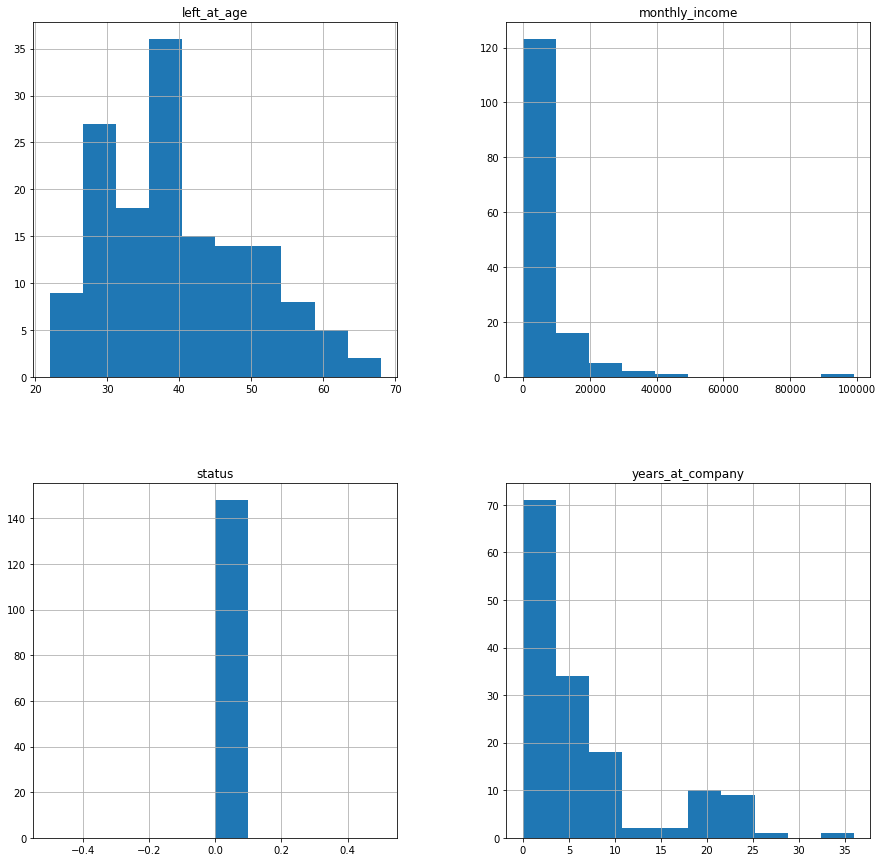

In [65]:
# data analysis for status = 0 -> people not anymore employeed in the company
import matplotlib.pyplot as plt

df_output[df_output['status'] == 0].describe()
df_output[df_output['status'] == 0].hist(figsize=(15,15))
plt.show()

Splitting data into training and testing sets

In [67]:
df_HR = df_output.copy()
# assign the target to a new dataframe and convert it to a numerical feature
#df_target = df_HR[['Attrition']].copy()
target = df_HR['status'].copy()

In [68]:
# let's remove the target feature and redundant features from the dataset
df_HR.drop(['lastName', 'firstName', 'status',
            'user-id'], axis=1, inplace=True)
print('Size of Full dataset is: {}'.format(df_HR.shape))

Size of Full dataset is: (454, 3)


In [69]:
# Since we have class imbalance (i.e. more employees with turnover=0 than turnover=1)
# let's use stratify=y to maintain the same ratio as in the training dataset when splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(df_HR,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=7,
                                                    stratify=target)  
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (340, 3)
Number transactions y_train dataset:  (340,)
Number transactions X_test dataset:  (114, 3)
Number transactions y_test dataset:  (114,)


## Random Forest

In [70]:
rf_classifier = RandomForestClassifier(class_weight = "balanced",
                                       random_state=7)
param_grid = {'n_estimators': [50, 75, 100, 125, 150, 175],
              'min_samples_split':[2,4,6,8,10],
              'min_samples_leaf': [1, 2, 3, 4],
              'max_depth': [5, 10, 15, 20, 25]}

grid_obj = GridSearchCV(rf_classifier,
                        iid=True,
                        return_train_score=True,
                        param_grid=param_grid,
                        scoring='roc_auc',
                        cv=10)

grid_fit = grid_obj.fit(X_train, y_train)
rf_opt = grid_fit.best_estimator_

print('='*20)
print("best params: " + str(grid_obj.best_estimator_))
print("best params: " + str(grid_obj.best_params_))
print('best score:', grid_obj.best_score_)
print('='*20)

C:\Users\Rybak\.conda\envs\HRMachineLearning\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


best params: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=175,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)
best params: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 175}
best score: 0.7556159420289855


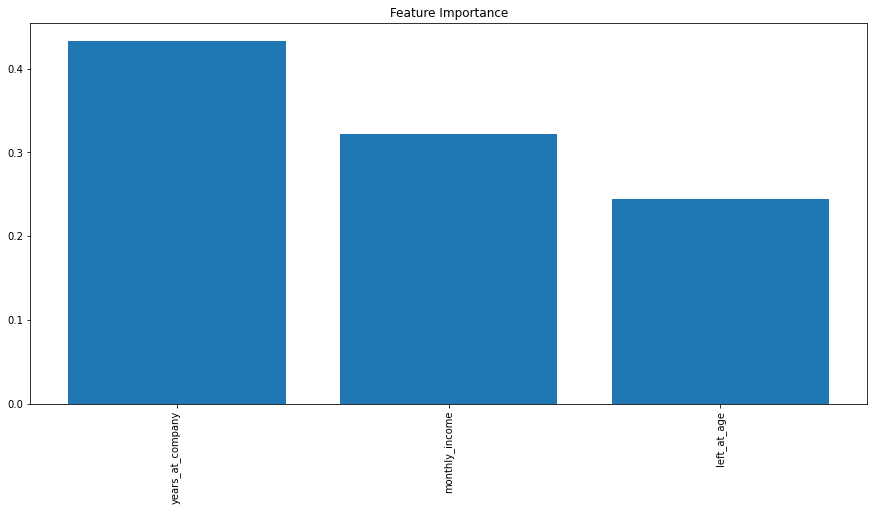

In [71]:
importances = rf_opt.feature_importances_
indices = np.argsort(importances)[::-1] # Sort feature importances in descending order
names = [X_train.columns[i] for i in indices] # Rearrange feature names so they match the sorted feature importances
plt.figure(figsize=(15, 7)) # Create plot
plt.title("Feature Importance") # Create plot title
plt.bar(range(X_train.shape[1]), importances[indices]) # Add bars
plt.xticks(range(X_train.shape[1]), names, rotation=90) # Add feature names as x-axis labels
plt.show() # Show plot

In [72]:
#save model
filename = "randomForest_SF"
pickle.dump(rf_opt, open(filename, 'wb'))

# Load Model

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))

# Predictions

In [76]:
df_output['prediction'] = rf_opt.predict(df_output[['left_at_age', 'years_at_company', 'monthly_income']])

In [77]:
df_output.head()

,lastName,firstName,status,user-id,left_at_age,years_at_company,monthly_income,prediction
1,Trombley,Francois,1,1,41,10,6763.260000,1
132,Schmidt,Michael,1,1000971,45,5,5463.417466,1
48,Williams,John,1,100112,61,3,14813.443200,1
7787,Cooper,Mya,0,100115,38,23,10184.242200,0
8907,Davis,Sarah,0,100135,56,23,22220.164800,0


# Output

In [78]:
#Save data to XLSX
df_output.to_excel('Data/output.xlsx', )